# CondDensityEstimator Hyperparameter Tuning with Optuna

In this notebook, we will use Optuna to tune the hyperparameters of a 
conditional density estimator (CDE). [Optuna](https://optuna.org/) is a 
framework-agnostic hyperparameter tuning package. Given a range of 
hyperparameters, it traverses this space in a smart way, exploring parameter
values that are more likely to maximize/minimize your objective. 

In this notebook, we will also take advantage of an early-stopping protocol, 
where Optuna looks at the validation loss at each epoch of network training and
stops the trial if it is unlikely to beat the best set of hyperparameters
found so far.

Before starting, please make sure you have `keras` and `optuna` installed
in your environment.
<!--- TODO: figure out what the requirement versions are --> 

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import visual_bars.generate_visual_bars_data as vbd
from cfl.experiment import Experiment

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from keras import Sequential
from keras.layers import Dense, Dropout
# TODO: install keras in requirements or instructions here

Using TensorFlow backend.


## Load Data
We will be using the visual bars example data for this tutorial. To learn 
more about this included dataset, please refer to the visual bars background
[page](https://cfl.readthedocs.io/en/latest/more_info/Visual_Bars_data.html).
If you would like to see a standard example of running CFL on this dataset
without hyperparameter tuning, please refer to the main CFL code 
[tutorial](https://cfl.readthedocs.io/en/latest/examples/cfl_code_intro.html).

Here, we create a dataset of 10000 samples, where the cause is a 10x10 image
and the effect is a binary 1D variable. For sake of simplicity, we will be
tuning a standard feed-forward network (as opposed to a convolutional 
neural network), so flatten the images down to vectors of shape (1,100). 

Since we want to evaluate our models on the same subset of the data across
all hyperparameter combinations, we generate in-sample and out-of-sample
indices to pass to CFL. If these are not provided, CFL generates this
split randomly, and it would look different across every trial. 

In [2]:
# create visual bars data 
n_samples = 20000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, 
                             noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X = vb_data.getImages()
X = np.reshape(X, (X.shape[0], np.product(X.shape[1:]))) # flatten images
Y = vb_data.getTarget()
Y = np.expand_dims(Y, -1)
print(X.shape)
print(Y.shape)

# define train and validation sets to remain constant across tuning
in_sample_idx, out_sample_idx = train_test_split(np.arange(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

(20000, 100)
(20000, 1)


## Make a CDE network

Next, we need to outline the architecture of our neural network. We use
Optuna's `trial.suggest_xxx` methods to determine the number of layers, number
of units in each layer, and the amount of dropout after each layer in the
network. For more information on how to use Optuna to suggest hyperparameters,
please refer to their [documentation](https://optuna.org/).

In [3]:
def build_network(trial):
    
    # vary number of layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    model = Sequential()
    
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))

    return model

## Define the tuning objective

Optuna takes in an `objective` function to perform tuning over. An objective
function should, assuming some set of hyperparameters generated by the
current optuna trial, 1) build our model of interest, 2) run the model, and
3) evaluate the model and return some metric of how well it did.

Here, we define the parameters for a CFL Experiment that contains one Block - 
a CDE. Specifically, we use a 'CondExpDIY' CDE because 1) we want to estimate
the conditional expectation of P(Y|X) instead of the full distribution for
computational esse, and 2) we want to provide our own model (defined above) 
instead of using a pre-defined model that CFL supplies.

Note that some of the parameters in `CDE_params` ('lr' and 'batch_size') are 
also defined by Optuna `trial.suggest_xxx` methods and will be optimized in
the same way as the network architecutre parameters.

Lastly, once the CDE has been trained, we pull the final validation loss
from the packaged cfl results and return it as our evaluation of the current
set of hyperparameters.

In [4]:
def objective(trial):

    # define the parameters for a CFL Experiment
    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

    CDE_params = {
        'model'           : 'CondExpDIY',
        'optuna_callback' : TFKerasPruningCallback(trial, "val_loss"),
        'optuna_trial'    : trial,
        'build_network'     : build_network,

        'lr'              : trial.suggest_float("lr", 1e-5, 1e-1, log=True),                
        'batch_size'      : trial.suggest_int("batch_size", 16, 128),
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'loss'            : 'mean_squared_error',
        'best'            : True, 
        'verbose'         : 0,
        'early_stopping'  : True,
    }

    block_names = ['CondDensityEstimator']
    block_params = [CDE_params]

    my_exp = Experiment(X_train=X, 
                        Y_train=Y, 
                        in_sample_idx=in_sample_idx,
                        out_sample_idx=out_sample_idx,
                        data_info=data_info, 
                        block_names=block_names, 
                        block_params=block_params, 
                        verbose=0,
                        results_path=None) # we don't want to save 100's of results

    train_results = my_exp.train()     
    score = train_results['CondDensityEstimator']['val_loss'][-1]
    return score

## Run an Optuna study

Finally, we are ready to optimize our hyperparameters. We first create
a 'study' which will minimize the score returned by `objective` above, and
will prune training during trials where the validation loss isn't dropping
at a promising rate.

We call `study.optimize` to try 50 different samples of hyperparameters from
the space we described with the `trial.suggest_xxx` methods.

By setting `show_plot` to `True` in `CDE_params`, we can visualize how the 
loss varies across different hyperparameter combinations.

[I 2022-02-07 12:03:18,383] A new study created in memory with name: no-name-8d0799d2-5a7e-4ca5-855e-251034ee1dee


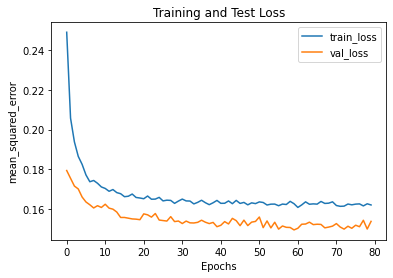

[I 2022-02-07 12:04:27,251] Trial 0 finished with value: 0.1538619754910469 and parameters: {'lr': 0.0899736060666178, 'batch_size': 60, 'n_layers': 2, 'n_units_l0': 4, 'dropout_l0': 0.1890024795909292, 'n_units_l1': 8, 'dropout_l1': 0.2528140645075728}. Best is trial 0 with value: 0.1538619754910469.


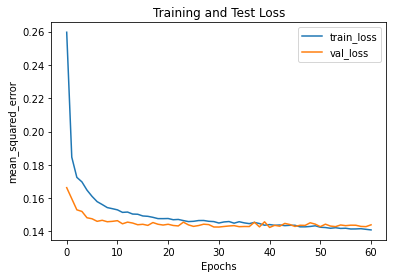

[I 2022-02-07 12:06:17,315] Trial 1 finished with value: 0.143977047803998 and parameters: {'lr': 0.002038065169276526, 'batch_size': 26, 'n_layers': 2, 'n_units_l0': 6, 'dropout_l0': 0.07737259321990941, 'n_units_l1': 9, 'dropout_l1': 0.15495346714139102}. Best is trial 1 with value: 0.143977047803998.


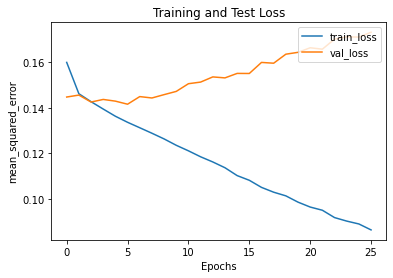

[I 2022-02-07 12:07:01,521] Trial 2 finished with value: 0.17318376366496085 and parameters: {'lr': 0.0009154020263182477, 'batch_size': 89, 'n_layers': 2, 'n_units_l0': 132, 'dropout_l0': 0.07375776446240162, 'n_units_l1': 140, 'dropout_l1': 0.0066945650845013915}. Best is trial 1 with value: 0.143977047803998.


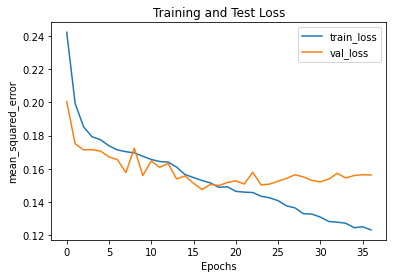

[I 2022-02-07 12:08:45,374] Trial 3 finished with value: 0.1562542676076293 and parameters: {'lr': 5.864932189777021e-05, 'batch_size': 59, 'n_layers': 4, 'n_units_l0': 211, 'dropout_l0': 0.3315674315689916, 'n_units_l1': 134, 'dropout_l1': 0.44930060631690133, 'n_units_l2': 19, 'dropout_l2': 0.1425846097077894, 'n_units_l3': 13, 'dropout_l3': 0.3291693136172141}. Best is trial 1 with value: 0.143977047803998.


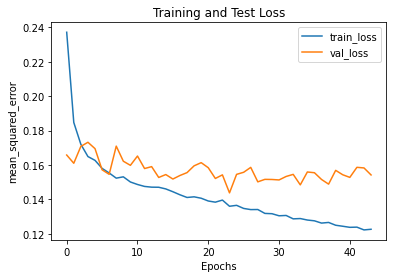

[I 2022-02-07 12:09:59,864] Trial 4 finished with value: 0.1542061397343874 and parameters: {'lr': 4.4873134111575336e-05, 'batch_size': 119, 'n_layers': 4, 'n_units_l0': 74, 'dropout_l0': 0.3292059115589699, 'n_units_l1': 168, 'dropout_l1': 0.39264239931772116, 'n_units_l2': 8, 'dropout_l2': 0.10628256532486291, 'n_units_l3': 53, 'dropout_l3': 0.22577868039925342}. Best is trial 1 with value: 0.143977047803998.
[I 2022-02-07 12:10:07,798] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2022-02-07 12:10:10,371] Trial 6 pruned. Trial was pruned at epoch 0.


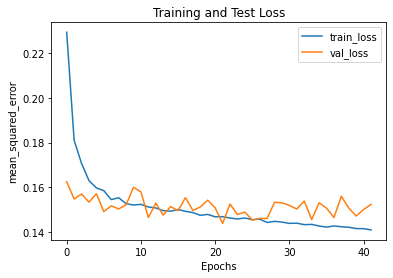

[I 2022-02-07 12:10:58,852] Trial 7 finished with value: 0.15239397169649602 and parameters: {'lr': 0.001887832218622041, 'batch_size': 89, 'n_layers': 2, 'n_units_l0': 13, 'dropout_l0': 0.1822165375978445, 'n_units_l1': 125, 'dropout_l1': 0.48955082951915524}. Best is trial 1 with value: 0.143977047803998.
[I 2022-02-07 12:11:02,826] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:11:05,839] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:11:24,758] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:11:35,105] Trial 11 pruned. Trial was pruned at epoch 0.


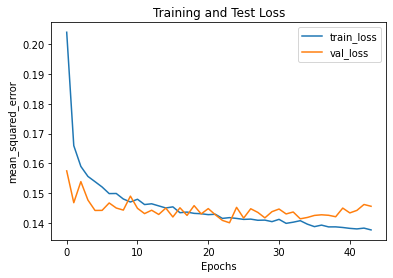

[I 2022-02-07 12:12:29,329] Trial 12 finished with value: 0.1455678819745779 and parameters: {'lr': 0.0010271188179496362, 'batch_size': 94, 'n_layers': 3, 'n_units_l0': 9, 'dropout_l0': 0.03135546159085162, 'n_units_l1': 57, 'dropout_l1': 0.13566896117583677, 'n_units_l2': 85, 'dropout_l2': 0.31279408722171}. Best is trial 1 with value: 0.143977047803998.
[I 2022-02-07 12:12:35,792] Trial 13 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:12:44,634] Trial 14 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:12:51,572] Trial 15 pruned. Trial was pruned at epoch 0.


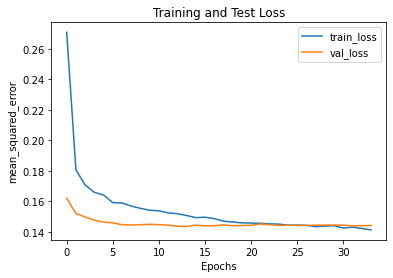

[I 2022-02-07 12:13:13,241] Trial 16 finished with value: 0.1441091538220644 and parameters: {'lr': 0.0013718544373455828, 'batch_size': 75, 'n_layers': 1, 'n_units_l0': 10, 'dropout_l0': 0.14224745074805542}. Best is trial 1 with value: 0.143977047803998.


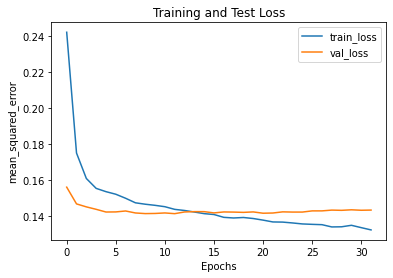

[I 2022-02-07 12:13:42,431] Trial 17 finished with value: 0.14351385338306427 and parameters: {'lr': 0.013727480408379397, 'batch_size': 72, 'n_layers': 1, 'n_units_l0': 34, 'dropout_l0': 0.2536721079801685}. Best is trial 17 with value: 0.14351385338306427.


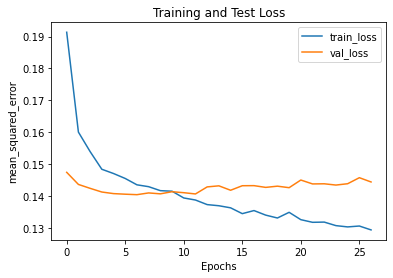

[I 2022-02-07 12:14:20,120] Trial 18 finished with value: 0.14449367949813605 and parameters: {'lr': 0.017524488716746046, 'batch_size': 43, 'n_layers': 1, 'n_units_l0': 53, 'dropout_l0': 0.25435796731432303}. Best is trial 17 with value: 0.14351385338306427.


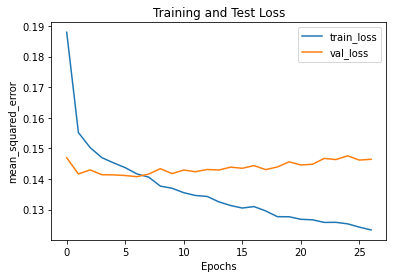

[I 2022-02-07 12:15:14,834] Trial 19 finished with value: 0.14644062390327453 and parameters: {'lr': 0.023453367077240172, 'batch_size': 32, 'n_layers': 1, 'n_units_l0': 116, 'dropout_l0': 0.39318991297999906}. Best is trial 17 with value: 0.14351385338306427.
[I 2022-02-07 12:15:20,827] Trial 20 pruned. Trial was pruned at epoch 0.


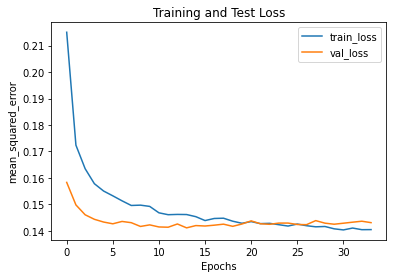

[I 2022-02-07 12:15:45,998] Trial 21 finished with value: 0.14313272479474545 and parameters: {'lr': 0.010470729559653924, 'batch_size': 74, 'n_layers': 1, 'n_units_l0': 14, 'dropout_l0': 0.1372223443377042}. Best is trial 21 with value: 0.14313272479474545.


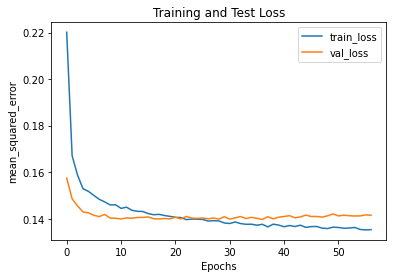

[I 2022-02-07 12:16:34,022] Trial 22 finished with value: 0.14148698992431163 and parameters: {'lr': 0.011396816623542274, 'batch_size': 54, 'n_layers': 1, 'n_units_l0': 17, 'dropout_l0': 0.14001841960024639}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:16:40,137] Trial 23 pruned. Trial was pruned at epoch 1.


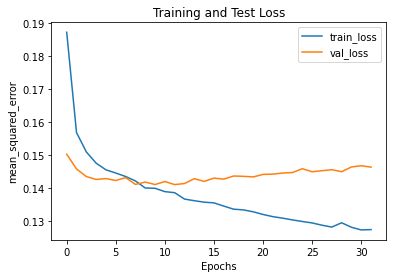

[I 2022-02-07 12:17:09,563] Trial 24 finished with value: 0.14627623531222345 and parameters: {'lr': 0.057645762651576817, 'batch_size': 70, 'n_layers': 1, 'n_units_l0': 46, 'dropout_l0': 0.15427114288707666}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:17:14,473] Trial 25 pruned. Trial was pruned at epoch 0.


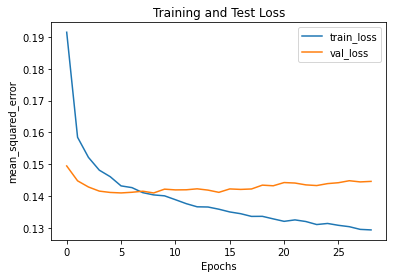

[I 2022-02-07 12:17:46,160] Trial 26 finished with value: 0.1446155885592103 and parameters: {'lr': 0.03930883122527414, 'batch_size': 49, 'n_layers': 1, 'n_units_l0': 30, 'dropout_l0': 0.11621216202816813}. Best is trial 22 with value: 0.14148698992431163.


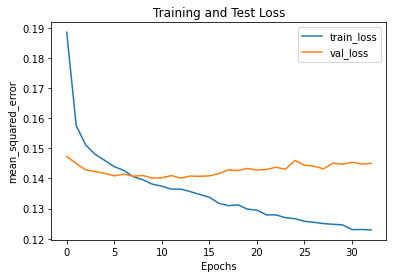

[I 2022-02-07 12:18:21,390] Trial 27 finished with value: 0.1449788090378046 and parameters: {'lr': 0.009376659454976146, 'batch_size': 66, 'n_layers': 1, 'n_units_l0': 69, 'dropout_l0': 0.2190665319181201}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:18:29,993] Trial 28 pruned. Trial was pruned at epoch 1.
[I 2022-02-07 12:18:33,491] Trial 29 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:18:38,696] Trial 30 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:18:45,278] Trial 31 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:18:49,090] Trial 32 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:18:53,891] Trial 33 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:19:02,486] Trial 34 pruned. Trial was pruned at epoch 1.
[I 2022-02-07 12:19:09,746] Trial 35 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:19:14,751] Trial 36 pruned. Trial was pruned at epoch 0.


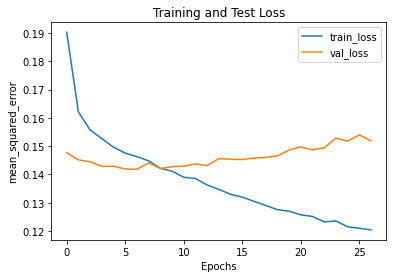

[I 2022-02-07 12:20:01,200] Trial 37 finished with value: 0.15185643476992847 and parameters: {'lr': 0.004356594428482152, 'batch_size': 45, 'n_layers': 2, 'n_units_l0': 66, 'dropout_l0': 0.1241158199340892, 'n_units_l1': 11, 'dropout_l1': 0.08710490110048202}. Best is trial 22 with value: 0.14148698992431163.


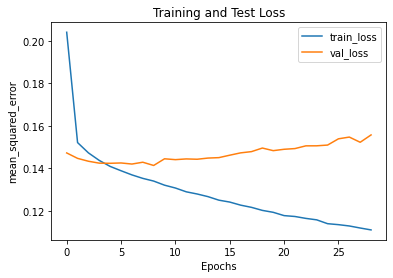

[I 2022-02-07 12:20:32,996] Trial 38 finished with value: 0.15576014623641968 and parameters: {'lr': 0.019532232660257547, 'batch_size': 84, 'n_layers': 1, 'n_units_l0': 106, 'dropout_l0': 0.08184810903213774}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:20:39,357] Trial 39 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:20:44,732] Trial 40 pruned. Trial was pruned at epoch 1.
[I 2022-02-07 12:20:49,144] Trial 41 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:20:53,744] Trial 42 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:20:57,890] Trial 43 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:21:02,480] Trial 44 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:21:06,806] Trial 45 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:21:10,723] Trial 46 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:21:19,695] Trial 47 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:21:25,587] Trial 48 pruned. Trial was pruned at epoch 0.

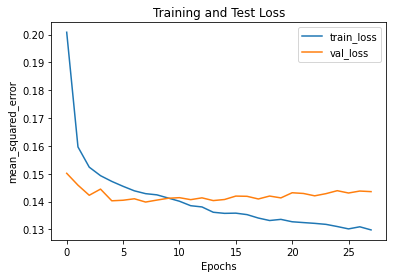

[I 2022-02-07 12:22:15,461] Trial 51 finished with value: 0.14358983173966408 and parameters: {'lr': 0.016652502680040995, 'batch_size': 43, 'n_layers': 1, 'n_units_l0': 56, 'dropout_l0': 0.2680502127147084}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:22:26,752] Trial 52 pruned. Trial was pruned at epoch 3.


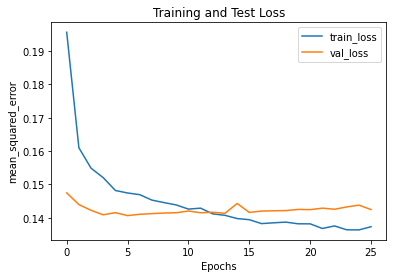

[I 2022-02-07 12:23:19,428] Trial 53 finished with value: 0.14246747595369816 and parameters: {'lr': 0.026651684057570044, 'batch_size': 22, 'n_layers': 1, 'n_units_l0': 39, 'dropout_l0': 0.3186737849474214}. Best is trial 22 with value: 0.14148698992431163.


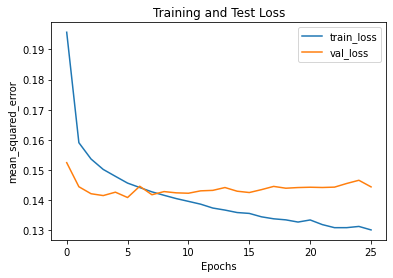

[I 2022-02-07 12:24:16,893] Trial 54 finished with value: 0.14442142178192735 and parameters: {'lr': 0.028891542578818246, 'batch_size': 23, 'n_layers': 1, 'n_units_l0': 51, 'dropout_l0': 0.32136831450434283}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:24:33,875] Trial 55 pruned. Trial was pruned at epoch 0.


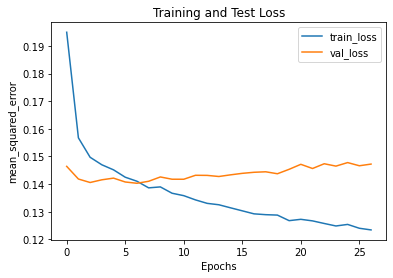

[I 2022-02-07 12:25:27,380] Trial 56 finished with value: 0.1472555582240224 and parameters: {'lr': 0.022756489153767625, 'batch_size': 29, 'n_layers': 1, 'n_units_l0': 83, 'dropout_l0': 0.3078531966439422}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:25:32,102] Trial 57 pruned. Trial was pruned at epoch 0.


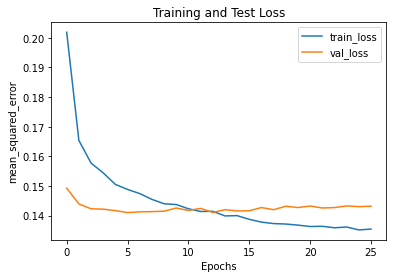

[I 2022-02-07 12:26:08,391] Trial 58 finished with value: 0.1431491413593292 and parameters: {'lr': 0.012488478942235199, 'batch_size': 38, 'n_layers': 1, 'n_units_l0': 35, 'dropout_l0': 0.29333254219016885}. Best is trial 22 with value: 0.14148698992431163.


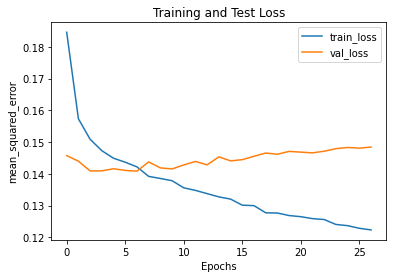

[I 2022-02-07 12:26:53,444] Trial 59 finished with value: 0.14843189488947392 and parameters: {'lr': 0.012485559193346308, 'batch_size': 37, 'n_layers': 1, 'n_units_l0': 83, 'dropout_l0': 0.29842846669774414}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:26:59,881] Trial 60 pruned. Trial was pruned at epoch 0.


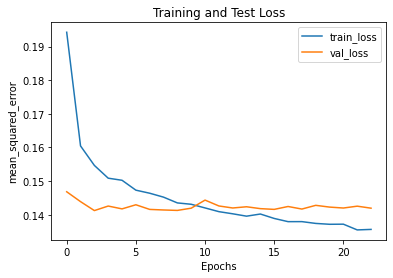

[I 2022-02-07 12:27:46,072] Trial 61 finished with value: 0.1419277888596058 and parameters: {'lr': 0.041379287528899175, 'batch_size': 24, 'n_layers': 1, 'n_units_l0': 44, 'dropout_l0': 0.33535963966373944}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:27:56,355] Trial 62 pruned. Trial was pruned at epoch 3.


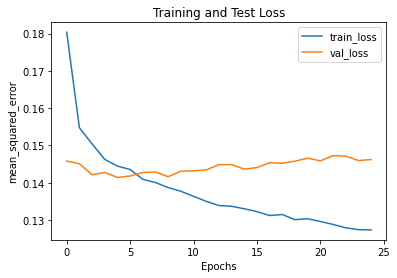

[I 2022-02-07 12:28:58,082] Trial 63 finished with value: 0.14621615269035101 and parameters: {'lr': 0.09942607142913155, 'batch_size': 20, 'n_layers': 1, 'n_units_l0': 63, 'dropout_l0': 0.2735839322678758}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:29:02,489] Trial 64 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:29:06,509] Trial 65 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:29:11,377] Trial 66 pruned. Trial was pruned at epoch 0.


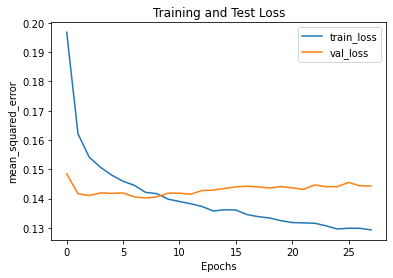

[I 2022-02-07 12:30:13,312] Trial 67 finished with value: 0.14427983129918576 and parameters: {'lr': 0.01004203635280496, 'batch_size': 27, 'n_layers': 1, 'n_units_l0': 54, 'dropout_l0': 0.3185639667072968}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:30:18,943] Trial 68 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:30:23,800] Trial 69 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:30:36,788] Trial 70 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:30:48,254] Trial 71 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:30:56,277] Trial 72 pruned. Trial was pruned at epoch 2.
[I 2022-02-07 12:31:01,637] Trial 73 pruned. Trial was pruned at epoch 0.


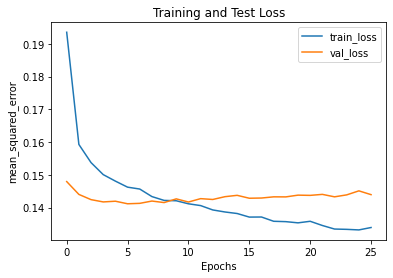

[I 2022-02-07 12:31:45,863] Trial 74 finished with value: 0.1439628124475479 and parameters: {'lr': 0.02853803325813763, 'batch_size': 26, 'n_layers': 1, 'n_units_l0': 29, 'dropout_l0': 0.21463757669519165}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:32:02,872] Trial 75 pruned. Trial was pruned at epoch 5.
[I 2022-02-07 12:32:07,039] Trial 76 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:32:19,846] Trial 77 pruned. Trial was pruned at epoch 5.
[I 2022-02-07 12:32:23,829] Trial 78 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:32:29,534] Trial 79 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:32:34,488] Trial 80 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:32:51,837] Trial 81 pruned. Trial was pruned at epoch 1.
[I 2022-02-07 12:32:57,480] Trial 82 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:33:09,708] Trial 83 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:33:21,639] Trial 84 pruned. Trial was pruned at epoch 0.
[I

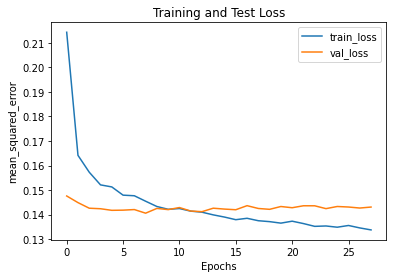

[I 2022-02-07 12:35:16,445] Trial 86 finished with value: 0.14309074266403912 and parameters: {'lr': 0.03281756957062822, 'batch_size': 17, 'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.3506083642932006}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:35:22,298] Trial 87 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:35:33,398] Trial 88 pruned. Trial was pruned at epoch 2.
[I 2022-02-07 12:35:40,834] Trial 89 pruned. Trial was pruned at epoch 1.
[I 2022-02-07 12:35:45,112] Trial 90 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:35:52,341] Trial 91 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:35:58,785] Trial 92 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:36:12,538] Trial 93 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:36:17,812] Trial 94 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:36:22,906] Trial 95 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:36:34,991] Trial 96 pruned. Trial was pruned at epoch 2.
[I

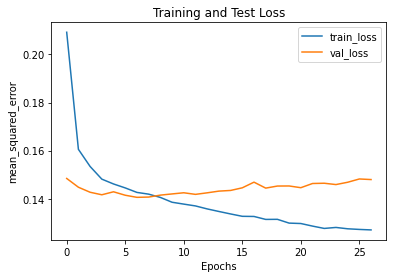

[I 2022-02-07 12:37:39,381] Trial 100 finished with value: 0.14797022193670273 and parameters: {'lr': 0.03531262630889648, 'batch_size': 40, 'n_layers': 1, 'n_units_l0': 57, 'dropout_l0': 0.23439545198927556}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:37:44,344] Trial 101 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:37:49,841] Trial 102 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:37:54,316] Trial 103 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:38:00,640] Trial 104 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:38:04,982] Trial 105 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:38:09,666] Trial 106 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:38:17,641] Trial 107 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:38:22,456] Trial 108 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:38:29,912] Trial 109 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:38:38,591] Trial 110 pruned. Trial was pruned at

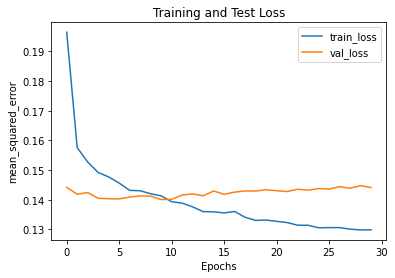

[I 2022-02-07 12:39:53,124] Trial 111 finished with value: 0.14411891721338033 and parameters: {'lr': 0.011342966385363954, 'batch_size': 26, 'n_layers': 1, 'n_units_l0': 56, 'dropout_l0': 0.31486621164063644}. Best is trial 22 with value: 0.14148698992431163.


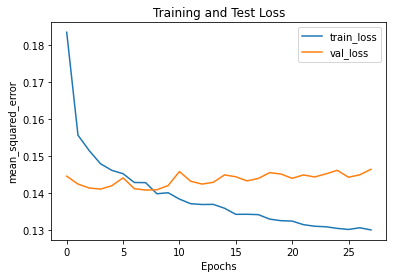

[I 2022-02-07 12:41:15,327] Trial 112 finished with value: 0.14646442408412694 and parameters: {'lr': 0.011320879054433118, 'batch_size': 18, 'n_layers': 1, 'n_units_l0': 65, 'dropout_l0': 0.3471162004951124}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:41:23,482] Trial 113 pruned. Trial was pruned at epoch 1.
[I 2022-02-07 12:41:36,233] Trial 114 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:41:41,864] Trial 115 pruned. Trial was pruned at epoch 0.


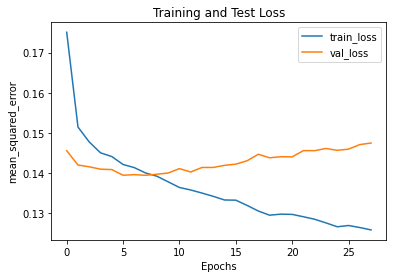

[I 2022-02-07 12:42:16,674] Trial 116 finished with value: 0.14742907704263924 and parameters: {'lr': 0.018018801354706484, 'batch_size': 47, 'n_layers': 1, 'n_units_l0': 40, 'dropout_l0': 0.09190936003391004}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:42:21,624] Trial 117 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:42:27,065] Trial 118 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:42:31,722] Trial 119 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:42:45,316] Trial 120 pruned. Trial was pruned at epoch 0.


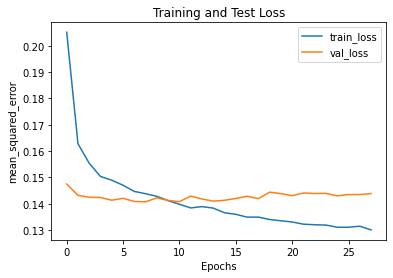

[I 2022-02-07 12:43:38,142] Trial 121 finished with value: 0.14388584114462138 and parameters: {'lr': 0.011083332141275277, 'batch_size': 31, 'n_layers': 1, 'n_units_l0': 54, 'dropout_l0': 0.31534132979868273}. Best is trial 22 with value: 0.14148698992431163.


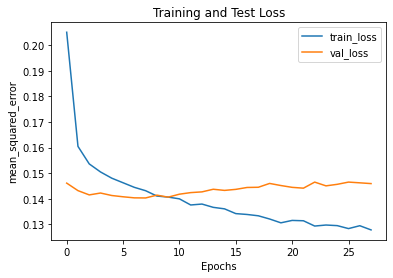

[I 2022-02-07 12:44:26,776] Trial 122 finished with value: 0.14592963439822196 and parameters: {'lr': 0.011864241469377113, 'batch_size': 36, 'n_layers': 1, 'n_units_l0': 62, 'dropout_l0': 0.3156870188669973}. Best is trial 22 with value: 0.14148698992431163.


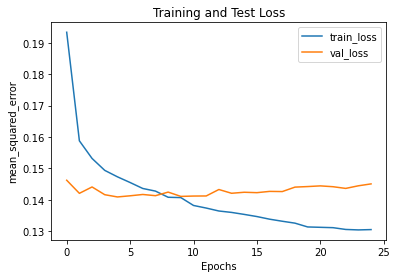

[I 2022-02-07 12:45:19,504] Trial 123 finished with value: 0.14504951260983945 and parameters: {'lr': 0.005884706886593468, 'batch_size': 30, 'n_layers': 1, 'n_units_l0': 53, 'dropout_l0': 0.2862659211946026}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:45:26,872] Trial 124 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:45:32,177] Trial 125 pruned. Trial was pruned at epoch 0.


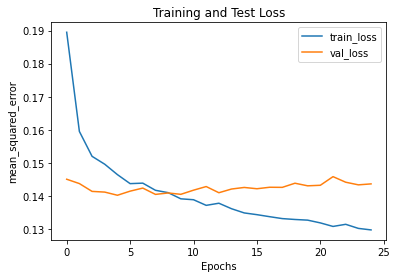

[I 2022-02-07 12:46:24,416] Trial 126 finished with value: 0.14362762008309365 and parameters: {'lr': 0.018991796333984796, 'batch_size': 28, 'n_layers': 1, 'n_units_l0': 76, 'dropout_l0': 0.3561070667597454}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:46:30,118] Trial 127 pruned. Trial was pruned at epoch 0.


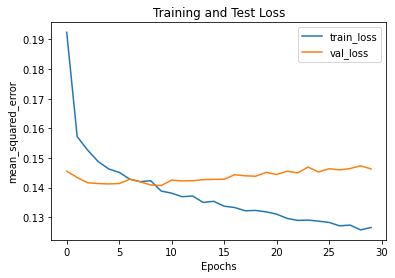

[I 2022-02-07 12:47:23,504] Trial 128 finished with value: 0.14632403605878352 and parameters: {'lr': 0.017177080035979595, 'batch_size': 34, 'n_layers': 1, 'n_units_l0': 68, 'dropout_l0': 0.3260346671075593}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:47:29,249] Trial 129 pruned. Trial was pruned at epoch 0.


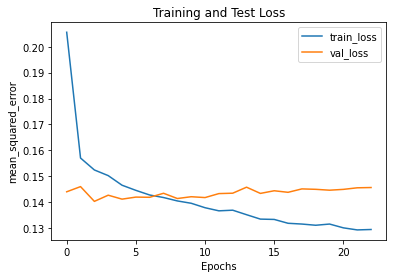

[I 2022-02-07 12:48:25,152] Trial 130 finished with value: 0.14566761319935323 and parameters: {'lr': 0.041092793721282495, 'batch_size': 23, 'n_layers': 1, 'n_units_l0': 79, 'dropout_l0': 0.3600812298329832}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:48:32,126] Trial 131 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:48:52,742] Trial 132 pruned. Trial was pruned at epoch 2.


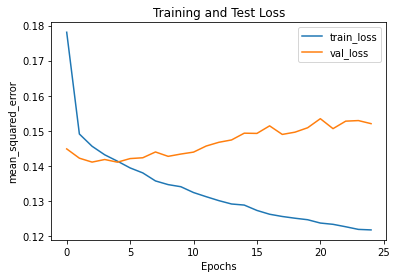

[I 2022-02-07 12:50:07,973] Trial 133 finished with value: 0.15202130883783102 and parameters: {'lr': 0.008175930284295481, 'batch_size': 19, 'n_layers': 1, 'n_units_l0': 38, 'dropout_l0': 0.04414139646110038}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:50:18,219] Trial 134 pruned. Trial was pruned at epoch 1.


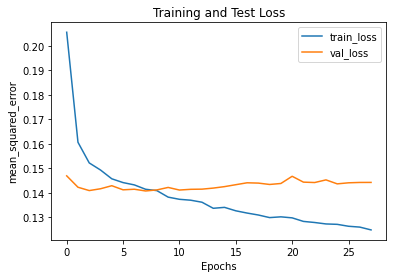

[I 2022-02-07 12:51:15,646] Trial 135 finished with value: 0.1442915116071701 and parameters: {'lr': 0.014432498889990417, 'batch_size': 32, 'n_layers': 1, 'n_units_l0': 74, 'dropout_l0': 0.33259603784759323}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:51:22,082] Trial 136 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:51:28,980] Trial 137 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:51:41,777] Trial 138 pruned. Trial was pruned at epoch 2.


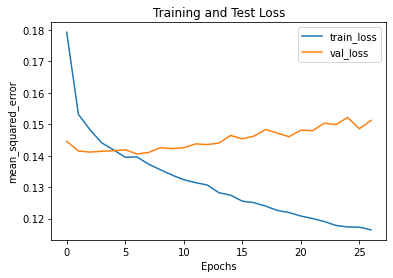

[I 2022-02-07 12:52:35,354] Trial 139 finished with value: 0.1512495554611087 and parameters: {'lr': 0.002413854800359089, 'batch_size': 35, 'n_layers': 1, 'n_units_l0': 115, 'dropout_l0': 0.2822166655416589}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:52:40,925] Trial 140 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:52:47,585] Trial 141 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:52:57,528] Trial 142 pruned. Trial was pruned at epoch 2.
[I 2022-02-07 12:53:04,312] Trial 143 pruned. Trial was pruned at epoch 0.


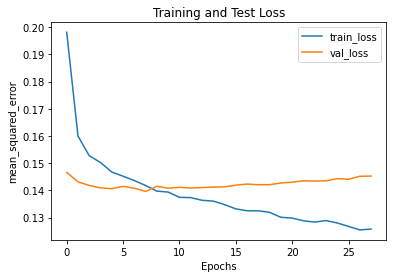

[I 2022-02-07 12:53:34,641] Trial 144 finished with value: 0.1452634951785207 and parameters: {'lr': 0.016268443442079335, 'batch_size': 69, 'n_layers': 1, 'n_units_l0': 73, 'dropout_l0': 0.2646588253901864}. Best is trial 22 with value: 0.14148698992431163.


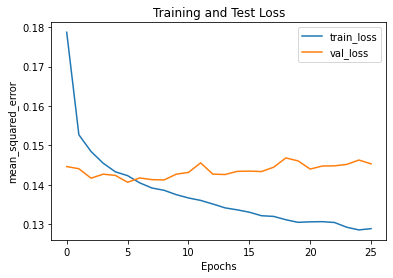

[I 2022-02-07 12:54:45,353] Trial 145 finished with value: 0.14531743798181415 and parameters: {'lr': 0.012404359562811568, 'batch_size': 17, 'n_layers': 1, 'n_units_l0': 33, 'dropout_l0': 0.14782126343469065}. Best is trial 22 with value: 0.14148698992431163.
[I 2022-02-07 12:54:53,619] Trial 146 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:54:59,896] Trial 147 pruned. Trial was pruned at epoch 0.
[I 2022-02-07 12:55:08,300] Trial 148 pruned. Trial was pruned at epoch 1.
[I 2022-02-07 12:55:14,512] Trial 149 pruned. Trial was pruned at epoch 0.


In [5]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=150)

## Print out `study` statistics and optimal hyperparameters found

In [6]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  150
  Number of pruned trials:  106
  Number of complete trials:  44
Best trial:
  Value:  0.14148698992431163
  Params: 
    lr: 0.011396816623542274
    batch_size: 54
    n_layers: 1
    n_units_l0: 17
    dropout_l0: 0.14001841960024639


## Rerun CFL with the optimized hyperparameters

Now, we run CFL with a CDE that is parameterized by the optimal hyperparameters 
printed out in the previous cell, and a CauseClusterer that uses the
expected conditional probability estimated in the previous step to construct
macrovariable states.

save_path 'demo_results' doesn't exist, creating now.
All results from this run will be saved to demo_results/experiment0000
#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...


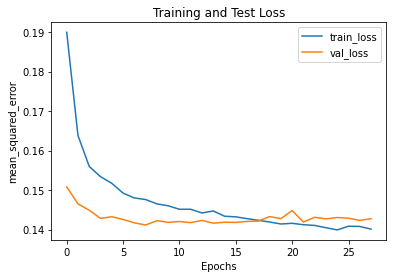

CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [7]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

CDE_params = {
    'model'           : 'CondExpDIY',
    'build_network'     : build_optimized_model,

    'lr'              : study.best_trial.params['lr'],                
    'batch_size'      : study.best_trial.params['batch_size'],
    'n_epochs'        : 100,
    'optimizer'       : 'adam',
    'loss'            : 'mean_squared_error',
    'best'            : True, 
    'verbose'         : 0,
    'early_stopping'  : True
}

cause_cluster_params = {'model' : 'KMeans', 'n_clusters' : 4, 'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, 
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params, 
                    results_path='demo_results')

train_results = my_exp.train()     

## Visualize the conditional probability learned by CFL with the optimized hyperparameters

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Sample', ylabel='Expectation of Target'>)

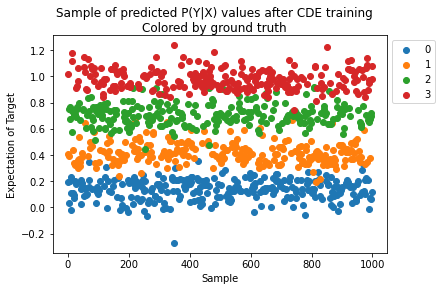

In [13]:
from cfl.visualization.cde_diagnostic import pyx_scatter
pyx_scatter(my_exp, vb_data.getGroundTruth())

## Visualize the macrovariable states that CFL finds with this set of hyperparameters

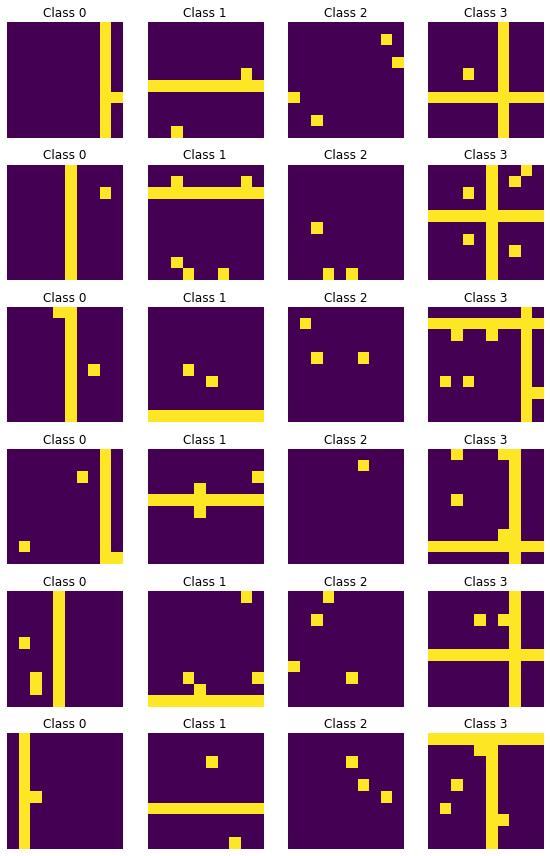

In [ ]:
import visual_bars.visual_bars_vis as vis

vis.viewImagesAndLabels(X, im_shape=im_shape, n_examples=6, 
                        x_lbls=train_results['CauseClusterer']['x_lbls'])